In [57]:
import tensorflow as tf
import numpy as np
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix
import time
from IPython.display import clear_output

In [58]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [59]:
def getImageFilePaths(filepath):
    full_path = filepath + '/*.jpg'
    return [f for f in glob(full_path)]

In [60]:
def get_images(filepath):
    filepaths = getImageFilePaths(filepath)
    return np.array([np.array(Image.open(f)) for f in filepaths])

In [61]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [62]:
def random_crop(image):
    return tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

In [63]:
def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)
    # random mirroring
    image = tf.image.random_flip_left_right(image)
    return image

In [64]:
def preprocess_image_train(image):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [65]:
def preprocess_image_test(image):
    image = normalize(image)
    return image

In [66]:
old_images = get_images('../data/kitchen/old')
modern_images = get_images('../data/kitchen/modern')
image_count = min(len(modern_images), len(old_images))
modern_images = modern_images[0:image_count]
old_images = old_images[0:image_count]

In [67]:
old_train_images, old_test_images = train_test_split(old_images, test_size=0.12, random_state=7)
modern_train_images, modern_test_images = train_test_split(modern_images, test_size=0.12, random_state=2)

In [68]:
old_train = tf.stack([preprocess_image_train(image) for image in old_train_images], axis=0)

In [69]:
old_test = tf.stack([preprocess_image_test(image) for image in old_test_images], axis=0)

In [70]:
modern_train = tf.stack([preprocess_image_train(image) for image in modern_train_images], axis=0)

In [71]:
modern_test = tf.stack([preprocess_image_test(image) for image in modern_test_images], axis=0)

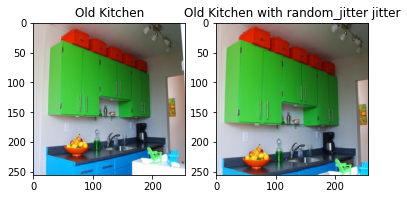

In [72]:
plt.subplot(121)
plt.title('Old Kitchen')
plt.imshow(old_train_images[0])

plt.subplot(122)
plt.title('Old Kitchen with random_jitter jitter')
plt.imshow(random_jitter(old_train_images[0]))

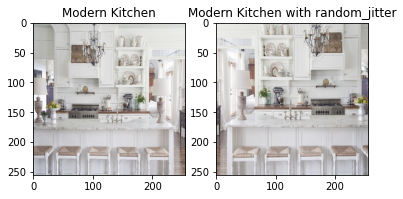

In [73]:
plt.subplot(121)
plt.title('Modern Kitchen')
plt.imshow(modern_train_images[0])

plt.subplot(122)
plt.title('Modern Kitchen with random_jitter')
plt.imshow(random_jitter(modern_train_images[0]))

In [18]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [19]:
to_modern = generator_g(old_train)

In [20]:
to_old = generator_f(modern_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


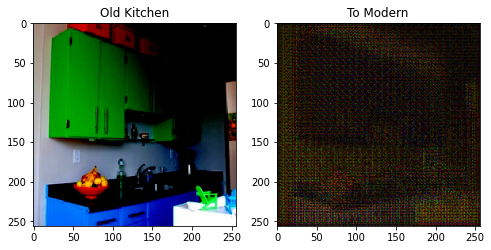

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


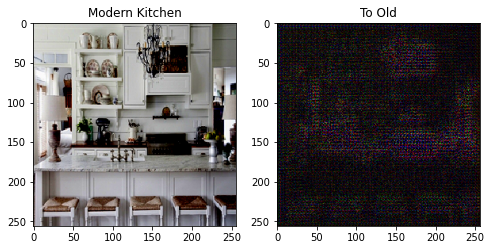

In [21]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Old Kitchen')
plt.imshow(old_train[0])

plt.subplot(122)
plt.title('To Modern')
plt.imshow(to_modern[0])

plt.show()

plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Modern Kitchen')
plt.imshow(modern_train[0])

plt.subplot(122)
plt.title('To Old')
plt.imshow(to_old[0])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


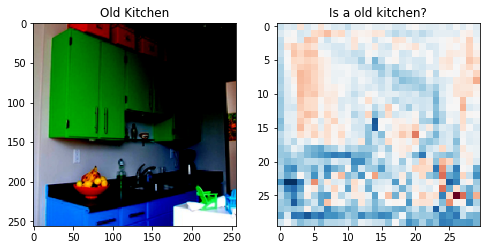

In [22]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Old Kitchen')
plt.imshow(old_train[0])

plt.subplot(122)
plt.title('Is a old kitchen?')
plt.imshow(discriminator_x(old_train)[0, ..., -1], cmap='RdBu_r')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


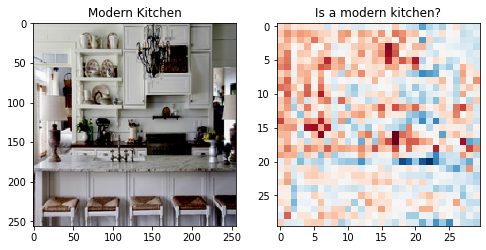

In [23]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Modern Kitchen')
plt.imshow(modern_train[0])

plt.subplot(122)
plt.title('Is a modern kitchen?')
plt.imshow(discriminator_y(modern_train)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [24]:
LAMBDA = 10

In [25]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [27]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [28]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [29]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [30]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [31]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [104]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [105]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [113]:
EPOCHS = 4

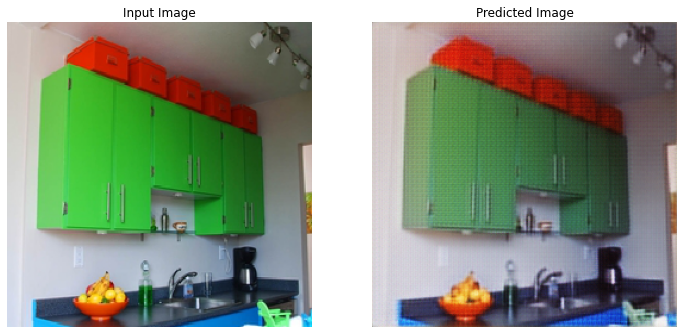

Saving checkpoint for epoch 2 at ./checkpoints/train/ckpt-7
Time taken for epoch 2 is 878.6338212490082 sec

...

In [ ]:
for epoch in range(EPOCHS):
    
    start = time.time()
    n = 0
    x_image = tf.split(old_train, 73)
    y_image = tf.split(modern_train, 73)
    for i in range(len(x_image)):
        train_step(x_image[i], y_image[i])
        if n % 10 == 0:
            print ('.', end='')
        n+=1
    
    clear_output(wait=True)
    # Using a consistent image (old_train) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, tf.split(old_train,len(old_train))[0])

    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

In [ ]:
train = tf.split(old_train,len(old_train))
for i in range(10):
    generate_images(generator_g, train[i])

In [ ]:
test = tf.split(old_test,len(old_test))
for i in range(10):
    generate_images(generator_g, test[i])

In [ ]:
train = tf.split(modern_train,len(modern_train))
for i in range(10):
    generate_images(generator_f, train[i])

In [ ]:
test = tf.split(modern_test,len(modern_test))
for i in range(10):
    generate_images(generator_f, test[i])